# DESI spectral extraction code benchmarks #

Stephen Bailey<br/>
Lawrence Berkeley National Lab<br/>
Early 2017

These benchmarks test the DESI spectral extraction code, which is the most computationally
intensive portion of our data processing pipeline.  It performs a forward modeling analysis
of astronomical spectra projected onto 2D CCD images.  Early non-KNL benchmarking indicated
that it was spending approximately 1/3 of its time in each of
  * MKL via `scipy.linalg.eigh`
  * Miscellaneous non-MKL compiled code in `numpy` and `scipy`
  * Miscellaneous pure python

We have not recently re-benchmarked this code and these benchmarks use a smaller example problem that may have a different ratio.

See the end of this notebook for how to get the code and run the benchmarks.

## Scaling with \$OMP_NUM_THREADS ##

Initial test: check if `$OMP_NUM_THREADS` matters for this code.  Takeaway points:
  * `$OMP_NUM_THREADS` doesn't matter for this code, presumably because it is spending
    most of its time in non-MKL / non-OpenMP code.
  * single process Haswell ~6.4x faster than single-process KNL
  
The remaining tests use `$OMP_NUM_THREADS=1`

In [1]:
%pylab inline
import numpy as np
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


ratio = 6.4


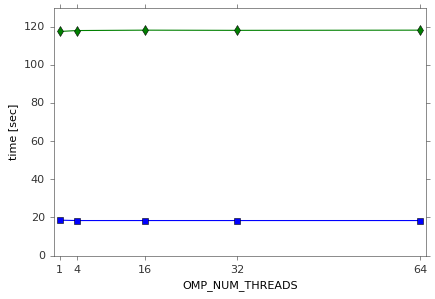

In [2]:
#- Scaling with OMP_NUM_THREADS (or not)
nt_hsw = Table.read('data/extract/ex-nthread-hsw-1.dat', format='ascii')
nt_knl = Table.read('data/extract/ex-nthread-knl-1.dat', format='ascii')

plot(nt_hsw['OMP_NUM_THREADS'], nt_hsw['time'], 'bs-')
plot(nt_knl['OMP_NUM_THREADS'], nt_knl['time'], 'gd-')
xlabel('OMP_NUM_THREADS'); ylabel('time [sec]')
xticks(nt_hsw['OMP_NUM_THREADS'], nt_hsw['OMP_NUM_THREADS'])
xlim(0,65); ylim(0,130)
ratio = np.max(nt_knl['time']) / np.max(nt_hsw['time'])
print('ratio = {:.1f}'.format(ratio))

## Scaling tests ##

Test the single node scaling performance for Haswell and KNL with two methods:
  * python multiprocessing
  * mpi4py
    
This is a data-parallel problem where different processes/ranks
are working on different pieces of data without needing to communicate
with each other.  Under ideal scaling each iteration
will take the same amount of well time such that more processes = more data processed
= higher total rate.  Takeaway points:

* Haswell multiprocessing and MPI have approximately the same scaling,
  more processes/ranks = more throughput.
* KNL multiprocessing and MPI don't scale at all; more processes/ranks = more time
  and same or worse throughput
* Given this non-scaling, a single Haswell node is almost 200x faster for this code than a
  single KNL node.
* Not shown here:
  * simpler tests have demonstrated that both multiprocessing and MPI can
    scale on a single KNL; we don't know what the difference is for this test.
  * On Haswell, not setting `$OMP_NUM_THREADS=1` clobbers performance at larger concurrency,
    even though the previous test indicated that `$OMP_NUM_THREADS > 1` doesn't help for
    a single process.

Note: `--bundlesize 25 --numwave 500` is a more realistic test of the size of problem that DESI is solving, but that runs so slowly I wasn't able to do viable benchmark scaling runs so
I trimmed it back to a smaller problem to study basic scaling performance and ratio of Haswell:KNL performance.

In [3]:
#- Scaling with OMP_NUM_THREADS (or not)
hsw_mpi = Table.read('data/extract/exmpi-hsw-1.dat', format='ascii')
knl_mpi = Table.read('data/extract/exmpi-knl-1.dat', format='ascii')
hsw_mp  = Table.read('data/extract/exmp-hsw-1.dat', format='ascii')
knl_mp  = Table.read('data/extract/exmp-knl-1.dat', format='ascii')

ratio of Haswell/KNL node rate = 192.0
ratio of Haswell/KNL process rate = 9.1
something is obviously wrong with KNL scaling


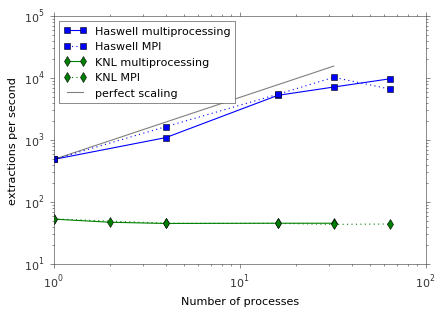

In [5]:
rcParams['legend.fontsize'] = 10
plot(hsw_mp['nproc'],  hsw_mp['rate'],  'bs-', label='Haswell multiprocessing')
plot(hsw_mpi['nproc'], hsw_mpi['rate'], 'bs:', label='Haswell MPI')
plot(knl_mp['nproc'],  knl_mp['rate'],  'gd-', label='KNL multiprocessing')
plot(knl_mpi['nproc'], knl_mpi['rate'], 'gd:', label='KNL MPI')
x = hsw_mp['nproc'][0:-1]
plot(x, hsw_mp['rate'][0]*x/x[0], 'k-', alpha=0.5, label='perfect scaling')
legend(loc='upper left')
xlabel('Number of processes'); ylabel('extractions per second')
loglog()
maxhsw = max(np.max(hsw_mp['rate']), np.max(hsw_mpi['rate']))
maxknl = max(np.max(knl_mp['rate']), np.max(knl_mpi['rate']))
print('ratio of Haswell/KNL node rate = {:.1f}'.format(maxhsw/maxknl))
print('ratio of Haswell/KNL process rate = {:.1f}'.format(hsw_mpi['rate'][0]/knl_mpi['rate'][0]))
print('something is obviously wrong with KNL scaling')
# savefig('extract-scaling.png')

In [7]:
np.max(knl_mp['rate']), np.max(hsw_mp['rate'])

(52.799999999999997, 9664.2000000000007)

# Setup to reproduce these results #

### Create a basic python environment ###
Start with an IDP or Anaconda distribution with numpy, scipy, astropy (and possibly others...), e.g.

```bash
conda create -n knltest python=3.5 numpy scipy astropy
source activate knltest
```

### Get the benchmark code ###

```bash
git clone https://github.com/sbailey/knltest
git clone https://github.com/desihub/specter

#- reference versions used for these tests
cd knltest; git checkout 065f961; cd ..
cd specter; git checkout 391ac23; cd ..

export PYTHONPATH=`pwd`/specter/py:$PYTHONPATH
cd knltest/code
export OMP_NUM_THREADS=1
```

### Run multiprocessing benchmark locally ###
This will run the extraction code with 1, 4, 16... parallel processes, where each
process is given the same amount of work to do.

```bash
python extract-mp.py 1 4 16 32 64
```

There is also an mpi4py version of this test which uses MPI ranks instead of multiprocessing processes.  In that case it will only use as many ranks as are specified in the options to `extract-mpi.py`.

### Run with SLURM to a KNL compute node ###
```bash
runknl="srun -N 1 -p regular -C knl,quad,cache -t 00:20:00"

#- Multiprocessing
$runknl -n 1 -c 256 python extract-mp.py 1 4 16 32 64 --bundlesize 5 --numwave 50

#- MPI: allocate just as many ranks as it will actually use
for n in 1 4 16; do
    $runknl -n $n -c 1 python extract-mpi.py $n --bundlesize 5 --numwave 50
done

#- MPI: allocate 16 ranks but use fewer of them, leaving others idle
#- This hurts MPI scaling performance and is *not* what was shown above
$runknl -n 16 -c 1 python extract-mpi.py 1 4 16 --bundlesize 5 --numwave 50
```